## Neural network for classification
Classification whether the company description belongs to the financial services sector or not

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_json('data_prep.json')

In [4]:
df['label'] = (df.sector == 'Financial Services').astype(int)
df.head()

,description,sector,label
0,Adara Acquisition Corp. does not have signific...,Financial Services,1
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,0
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,1
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,0
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,0


In [5]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [6]:
len(train), len(val)

(7866, 983)

In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    label = df.pop('label')
    df = dataframe["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, label))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    # ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [9]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [10]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(64, 50), dtype=float32, numpy=
array([[ 1.0382185 , -0.09464338,  0.49442896, ..., -0.2905217 ,
        -0.06509443,  0.57431597],
       [ 1.0737052 , -0.08938787,  0.4917559 , ..., -0.33144996,
        -0.3521311 ,  0.6548068 ],
       [ 0.5972559 , -0.429812  ,  0.4096976 , ...,  0.11742865,
        -0.69878227,  0.6036832 ],
       ...,
       [ 1.3094859 , -0.44474727,  0.5155948 , ..., -0.28199518,
        -0.6024845 ,  1.0224168 ],
       [ 0.38026482, -0.08878642,  0.54379827, ..., -0.16219848,
        -0.265038  ,  0.371504  ],
       [ 1.1313728 ,  0.0371999 ,  0.26991656, ..., -0.22568358,
        -0.460113  ,  0.79040325]], dtype=float32)>

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)  # text to numerical value transformation
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # here later softmax

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='BinaryCrossentropy',  # here later sparse_categorical_crossentropy
              metrics=['accuracy'])

In [13]:
model.evaluate(train_data)

123/123 [==============================] - 1s 2ms/step - loss: 0.6285 - accuracy: 0.7613


[0.6285071969032288, 0.7612509727478027]

In [14]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
123/123 [==============================] - 53s 427ms/step - loss: 0.3439 - accuracy: 0.8562 - val_loss: 0.0949 - val_accuracy: 0.9725
Epoch 2/5
123/123 [==============================] - 52s 419ms/step - loss: 0.1086 - accuracy: 0.9672 - val_loss: 0.0509 - val_accuracy: 0.9847
Epoch 3/5
123/123 [==============================] - 52s 420ms/step - loss: 0.0649 - accuracy: 0.9850 - val_loss: 0.0486 - val_accuracy: 0.9837
Epoch 4/5
123/123 [==============================] - 52s 421ms/step - loss: 0.0382 - accuracy: 0.9919 - val_loss: 0.0496 - val_accuracy: 0.9868
Epoch 5/5
123/123 [==============================] - 53s 428ms/step - loss: 0.0263 - accuracy: 0.9945 - val_loss: 0.0587 - val_accuracy: 0.9847


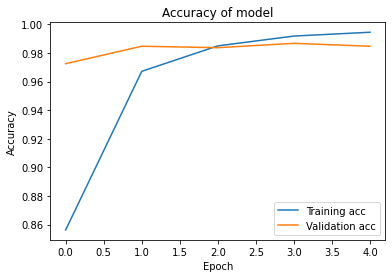

In [15]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

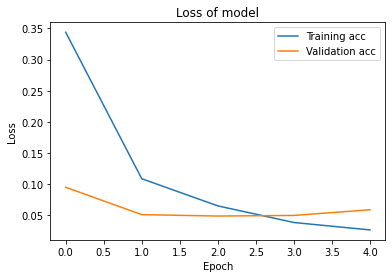

In [16]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [17]:
model.evaluate(test_data)

16/16 [==============================] - 1s 57ms/step - loss: 0.0777 - accuracy: 0.9858


[0.07771419733762741, 0.9857723712921143]